In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted

import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import inspect
import random
import shutil

from datetime import datetime
from dateutil.relativedelta import relativedelta

from scipy import optimize, ndimage
from sklearn import decomposition, cluster, model_selection, metrics
import sklearn

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import utils.dataset_utils as dataset
import utils.train_utils as train

import numpy.polynomial.polynomial as poly

In [2]:
def unit_vector_norm(X):
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

def split_Raman_af(X):
    """
    Removing spikes from the data to extract the autofluorescence.
    This is done by applying smoothing filter to the data and then taking the min of the smoothing filter and original data.
    """
    a = X
    c = 50

    # remove the top of the spikes from data, by using a Gaussian smoothing filter
    for _ in range(5):      
        a[:,c] = X[:,c]
        a[:,-c] = X[:,-c]      
        a1 = ndimage.gaussian_filter(a, (0, 30), mode='nearest')
        a = np.min([a, a1], axis=0)

    # remove the spikes from data, by using a polynominal fit
    for _ in range(5):
        a[:,c] = X[:,c]
        a[:,-c] = X[:,-c]        
        z = poly.polyfit(wavelength[::5], a[:,::5].T, 5)
        a1 = poly.polyval(wavelength, z)
        a = np.min([a, a1], axis=0)
        
    # smooth the curve the data, (to remove remnants of noise in the photoluminescence signal)
    for _ in range(10):           
        a[:,1] = X[:,1]
        a[:,-1] = X[:,-1]         
        a = ndimage.gaussian_filter(a, (0, 10), mode='nearest')

    # make the Raman signal non-negative, (to remove remnants of noise in the Raman signal)
    return (X-a).clip(min=0), a 

def smoothing(X, smooth=5, transition=10, spike_width=7):
    """
    Only remove noise from low noise to signal area's to maintain the intensity of the spikes.
    Noise is removed with a gaussian filter in spectral dimension.
    """
    grad = ndimage.gaussian_filter(X, (0, 1), order=1)
    grad_abs = np.abs(grad)
    grad_abs_sm = ndimage.gaussian_filter(grad_abs, (0, 5))
    mean_grad = np.mean(grad_abs, 1) + 1 / np.std(grad_abs, 1) * 3
    
    spikes = ((grad_abs_sm.T > mean_grad ).astype(float)).T 
    spikes = np.round(ndimage.gaussian_filter(spikes, (0, spike_width)))
    spikes = ndimage.uniform_filter(spikes, (0, transition))
    
    return (1 - spikes) * ndimage.gaussian_filter(X, (0,smooth)) + spikes * X

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [3]:
N_WAVE = 2126

X = np.load("../data/Raman/Alina_art_1_1.npy", 'r')[:,:,2:N_WAVE+2]
Y = np.load("../data/Raman/Alina_art_2_1.npy", 'r')
Z = np.load("../data/Raman/Alina_Art_4_2.npy", 'r')

wavelength = np.load("../data/Raman/wavelength.npy", 'r')

shape_X = X.shape 
shape_Y = Y.shape
shape_Z = Z.shape 

X = copy.copy(X.reshape(-1, X.shape[-1]))
X_smooth = smoothing(X)
ram_X, afl_X = split_Raman_af(X_smooth)

Y = copy.copy(Y.reshape(-1, Y.shape[-1]))
Y_smooth = smoothing(Y)
ram_Y, afl_Y = split_Raman_af(Y_smooth)

Z = copy.copy(Z.reshape(-1, Z.shape[-1]))
Z_smooth = smoothing(Z)
ram_Z, afl_Z = split_Raman_af(Z_smooth)


In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, n_components=10, depth=2, neurons=100, bias=True, **kwargs):
        super().__init__()
        self.encode = nn.Sequential( 
            nn.Dropout3d(0.25),
            nn.Flatten(),
            nn.Linear(N_WAVE, neurons, bias=bias),
            nn.ReLU(True),
            *((nn.Linear(neurons, neurons, bias=bias),
            nn.ReLU(True)) * (depth-1)),
            nn.Linear(neurons, n_components, bias=bias),
            nn.Softmax(1),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(n_components, neurons, bias=bias),
            nn.ReLU(True),
            *((nn.Linear(neurons, neurons, bias=bias),
            nn.ReLU(True)) * (depth-1)),            
            nn.Linear(neurons, N_WAVE, bias=bias),
            View((-1,1,1,1,N_WAVE)),
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))  

In [5]:
def MSE_loss(x, model):
    W = model.encode(x)
    x_ = model.decode(W)

    alpha = 0.8
    rho = 0.8
    
    max_ref_diff = alpha * torch.abs(W).sum(1).mean(0)        
    max_ref_diff += (1 - alpha) * ((W.sum(1))**2).mean(0)
        
    #MSE loss
    MSE = ((x_ - x)**2).sum(4).mean()  
    
    return rho * MSE + (1 - rho) * max_ref_diff

In [6]:
class ReferenceVectorClassifierAE(BaseEstimator):
    def __init__(self, **kwargs):
        self.kwargs = {}
        self.ae_kwargs = {}
        self.k_means_kwargs = {}                
        self.set_params(**kwargs)

        _use_cuda = torch.cuda.is_available() and kwargs['cuda']
        if _use_cuda:
            torch.backends.cudnn.enabled = True
            torch.backends.cudnn.benchmark = True
        self.device = torch.device('cuda' if _use_cuda else 'cpu')        
        
    def fit(self, x, **kwargs):
        self.set_params(**kwargs)
        X = unit_vector_norm(x)
        
        ###################### Autoencoder ################################
        self.model = AutoEncoder(**self.ae_kwargs).to(self.device)
        
        parameters = filter(lambda x: x.requires_grad, self.model.parameters())
        self.optimizer = optim.Adam(parameters)        
        train_loader, test_loader = dataset.load_liver(X, self.kwargs['batch_size'])
        
        for epoch in range(self.kwargs['epochs']):
            print('-'*50)
            print('Epoch {:3d}/{:3d}'.format(epoch+1, self.kwargs['epochs']))
            start_time = datetime.now()
            train.train(self.model, self.optimizer, train_loader, self.kwargs['loss_func'], self.kwargs['log_step'], self.device)
            end_time = datetime.now()
            time_diff = relativedelta(end_time, start_time)
            print('Elapsed time: {}h {}m {}s'.format(time_diff.hours, time_diff.minutes, time_diff.seconds))
            loss = train.test(self.model, test_loader, self.kwargs['loss_func'], self.device)
            print('Validation| bits: {:2.2f}'.format(loss), flush=True)    
          
        self.model.eval()
        with torch.no_grad():
            W = self.model.encode(dataset.load_liver_all(X).to(self.device))
        self.z = W
        W = W.cpu().detach().numpy()
        
        ###################### clustering ################################        
        self.clusters = cluster.KMeans(**self.k_means_kwargs).fit(W)
        self.clusters = self.clusters.labels_
        
        one_hot = np.zeros((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        one_hot[range(X.shape[0]), self.clusters] = 1
                          
        ###################### reference spectra ################################
        self.reference_spectra_ = unit_vector_norm(np.array([np.abs(x_) for i, x_ in enumerate(one_hot.T @ X)]))
        self.ref_org = np.array([x[one_hot[:,i],:].mean(axis=0) for i in range(self.kwargs['n_clusters'])])
               
        # Return the classifier
        return self
    
    def predict(self, X):
        """
        predict transforms the data into the reference space. Min weight should be 0 or higher then 'min_weight'
        The error is the NMSE, where the MSE is normalised by the signal strength. 
        error.shape = X.shape[0], so for each data point the error is calculated.
        """
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
        X = unit_vector_norm(X)
        
        ###################### RCA ################################           
        RCA_vector = np.array([optimize.nnls(self.reference_spectra_.T, X[i,:])[0] for i in range(X.shape[0])])

        return RCA_vector
    
    def get_reference_vectors(self):
        return self.reference_spectra_

    def get_org_reference_vectors(self):
        return self.ref_org    
    
    def get_params(self, deep=False):
        return self.kwargs
    
    def set_params(self, **kwargs):
        self.kwargs.update(kwargs)
        self.k_means_kwargs.update({k:v  for k,v in kwargs.items() if k in list(inspect.signature(cluster.KMeans).parameters.keys())})     
        self.ae_kwargs.update({k:v  for k,v in kwargs.items() if k in list(inspect.signature(AutoEncoder).parameters.keys())})     
        return self

In [7]:
def error_map(estimator, X, y=None):
    RCA = estimator.predict(X)
    ref_vec = estimator.get_reference_vectors()
    return ((RCA @ ref_vec - X)**2).sum(1)

def score_func(estimator, X, y=None):
    tmp = np.sqrt((X**2).sum(axis=1))
    X = unit_vector_norm(X)
    return (error_map(estimator, X) * tmp).mean()

def print_mean_std(X):
    return f"{X.mean():<12.4e}{X.std():<12.4e}"

def cross_val_X_Y_Z(rvc, X, Y, Z):
    rvc.fit(np.concatenate((X, Y), axis=0))
    return score_func(rvc, Z)

In [8]:
kwargs = {'n_components': 6,
          'n_clusters': 3,
          'batch_size': 32,
          'cuda': True,
          'log_step': 30,
          'loss_func': MSE_loss,
          'epochs': 20,
          'depth': 3,
          'neurons': 532,
          'bias': True
         }

In [ ]:
score = []
for i in range(10):
    print(i)
    rvc = ReferenceVectorClassifierAE(**kwargs)
    rvc.fit(ram_X)
    score.append(score_func(rvc, ram_X))
print(score)
print(np.mean(score), np.std(score))
del score[np.argmax(score)]
del score[np.argmin(score)]
print(score)
print(np.mean(score), np.std(score))

In [ ]:
score = []
for i in range(10):
    print(i)
    rvc = ReferenceVectorClassifierAE(**kwargs)
    rvc.fit(ram_Y)
    score.append(score_func(rvc, ram_Y))   
print(score)
print(np.mean(score), np.std(score))
del score[np.argmax(score)]
del score[np.argmin(score)]
print(score)
print(np.mean(score), np.std(score))

In [9]:
start_time = datetime.now()

score = []
for i in range(10):
    print(i)
    rvc = ReferenceVectorClassifierAE(**kwargs)
    rvc.fit(ram_Z)
    score.append(score_func(rvc, ram_Z))
end_time = datetime.now()
time_diff = relativedelta(end_time, start_time)
print('Elapsed time: {}h {}m {}s {}ms'.format(time_diff.hours, time_diff.minutes, time_diff.seconds, time_diff.microseconds/1000))
  
    
print(score)
print(np.mean(score), np.std(score))
del score[np.argmax(score)]
del score[np.argmin(score)]
print(score)
print(np.mean(score), np.std(score))

0
--------------------------------------------------
Epoch   1/ 20
  2020-07-19 17:32:44|     0/  178| bits: 2.79
  2020-07-19 17:32:45|    30/  178| bits: 0.29
  2020-07-19 17:32:45|    60/  178| bits: 0.23
  2020-07-19 17:32:45|    90/  178| bits: 0.24
  2020-07-19 17:32:46|   120/  178| bits: 0.22
  2020-07-19 17:32:46|   150/  178| bits: 0.23
Elapsed time: 0h 0m 4s
Validation| bits: 0.23
--------------------------------------------------
Epoch   2/ 20
  2020-07-19 17:32:50|     0/  178| bits: 0.23
  2020-07-19 17:32:51|    30/  178| bits: 0.22
  2020-07-19 17:32:51|    60/  178| bits: 0.23
  2020-07-19 17:32:51|    90/  178| bits: 0.23
  2020-07-19 17:32:52|   120/  178| bits: 0.22
  2020-07-19 17:32:52|   150/  178| bits: 0.25
Elapsed time: 0h 0m 3s
Validation| bits: 0.22
--------------------------------------------------
Epoch   3/ 20
  2020-07-19 17:32:56|     0/  178| bits: 0.23
  2020-07-19 17:32:57|    30/  178| bits: 0.23
  2020-07-19 17:32:57|    60/  178| bits: 0.25
  2020

Elapsed time: 0h 0m 3s
Validation| bits: 0.22
--------------------------------------------------
Epoch   2/ 20
  2020-07-19 17:34:50|     0/  178| bits: 0.29
  2020-07-19 17:34:51|    30/  178| bits: 0.27
  2020-07-19 17:34:51|    60/  178| bits: 0.24
  2020-07-19 17:34:51|    90/  178| bits: 0.24
  2020-07-19 17:34:52|   120/  178| bits: 0.24
  2020-07-19 17:34:52|   150/  178| bits: 0.30
Elapsed time: 0h 0m 3s
Validation| bits: 0.23
--------------------------------------------------
Epoch   3/ 20
  2020-07-19 17:34:56|     0/  178| bits: 0.22
  2020-07-19 17:34:57|    30/  178| bits: 0.23
  2020-07-19 17:34:57|    60/  178| bits: 0.24
  2020-07-19 17:34:57|    90/  178| bits: 0.27
  2020-07-19 17:34:58|   120/  178| bits: 0.28
  2020-07-19 17:34:58|   150/  178| bits: 0.23
Elapsed time: 0h 0m 3s
Validation| bits: 0.22
--------------------------------------------------
Epoch   4/ 20
  2020-07-19 17:35:02|     0/  178| bits: 0.25
  2020-07-19 17:35:03|    30/  178| bits: 0.28
  2020-07

  2020-07-19 17:37:07|   150/  178| bits: 0.26
Elapsed time: 0h 0m 3s
Validation| bits: 0.22
--------------------------------------------------
Epoch   3/ 20
  2020-07-19 17:37:11|     0/  178| bits: 0.21
  2020-07-19 17:37:11|    30/  178| bits: 0.24
  2020-07-19 17:37:11|    60/  178| bits: 0.24
  2020-07-19 17:37:11|    90/  178| bits: 0.25
  2020-07-19 17:37:12|   120/  178| bits: 0.22
  2020-07-19 17:37:12|   150/  178| bits: 0.22
Elapsed time: 0h 0m 3s
Validation| bits: 0.22
--------------------------------------------------
Epoch   4/ 20
  2020-07-19 17:37:16|     0/  178| bits: 0.27
  2020-07-19 17:37:16|    30/  178| bits: 0.22
  2020-07-19 17:37:17|    60/  178| bits: 0.26
  2020-07-19 17:37:17|    90/  178| bits: 0.29
  2020-07-19 17:37:17|   120/  178| bits: 0.21
  2020-07-19 17:37:18|   150/  178| bits: 0.21
Elapsed time: 0h 0m 3s
Validation| bits: 0.21
--------------------------------------------------
Epoch   5/ 20
  2020-07-19 17:37:22|     0/  178| bits: 0.23
  2020-07

  2020-07-19 17:39:10|   120/  178| bits: 0.24
  2020-07-19 17:39:10|   150/  178| bits: 0.22
Elapsed time: 0h 0m 4s
Validation| bits: 0.22
--------------------------------------------------
Epoch   4/ 20
  2020-07-19 17:39:17|     0/  178| bits: 0.26
  2020-07-19 17:39:17|    30/  178| bits: 0.25
  2020-07-19 17:39:18|    60/  178| bits: 0.23
  2020-07-19 17:39:18|    90/  178| bits: 0.21
  2020-07-19 17:39:19|   120/  178| bits: 0.21
  2020-07-19 17:39:19|   150/  178| bits: 0.21
Elapsed time: 0h 0m 5s
Validation| bits: 0.21
--------------------------------------------------
Epoch   5/ 20
  2020-07-19 17:39:25|     0/  178| bits: 0.24
  2020-07-19 17:39:26|    30/  178| bits: 0.22
  2020-07-19 17:39:26|    60/  178| bits: 0.29
  2020-07-19 17:39:27|    90/  178| bits: 0.23
  2020-07-19 17:39:27|   120/  178| bits: 0.21
  2020-07-19 17:39:28|   150/  178| bits: 0.25
Elapsed time: 0h 0m 5s
Validation| bits: 0.21
--------------------------------------------------
Epoch   6/ 20
  2020-07

  2020-07-19 17:41:30|    90/  178| bits: 0.21
  2020-07-19 17:41:30|   120/  178| bits: 0.24
  2020-07-19 17:41:31|   150/  178| bits: 0.25
Elapsed time: 0h 0m 3s
Validation| bits: 0.22
--------------------------------------------------
Epoch   5/ 20
  2020-07-19 17:41:35|     0/  178| bits: 0.21
  2020-07-19 17:41:35|    30/  178| bits: 0.24
  2020-07-19 17:41:36|    60/  178| bits: 0.21
  2020-07-19 17:41:36|    90/  178| bits: 0.28
  2020-07-19 17:41:36|   120/  178| bits: 0.34
  2020-07-19 17:41:37|   150/  178| bits: 0.21
Elapsed time: 0h 0m 3s
Validation| bits: 0.22
--------------------------------------------------
Epoch   6/ 20
  2020-07-19 17:41:40|     0/  178| bits: 0.29
  2020-07-19 17:41:41|    30/  178| bits: 0.23
  2020-07-19 17:41:41|    60/  178| bits: 0.27
  2020-07-19 17:41:41|    90/  178| bits: 0.24
  2020-07-19 17:41:42|   120/  178| bits: 0.23
  2020-07-19 17:41:42|   150/  178| bits: 0.22
Elapsed time: 0h 0m 3s
Validation| bits: 0.22
---------------------------

  2020-07-19 17:43:31|    60/  178| bits: 0.24
  2020-07-19 17:43:31|    90/  178| bits: 0.21
  2020-07-19 17:43:31|   120/  178| bits: 0.21
  2020-07-19 17:43:31|   150/  178| bits: 0.21
Elapsed time: 0h 0m 3s
Validation| bits: 0.21
--------------------------------------------------
Epoch   6/ 20
  2020-07-19 17:43:35|     0/  178| bits: 0.21
  2020-07-19 17:43:36|    30/  178| bits: 0.24
  2020-07-19 17:43:36|    60/  178| bits: 0.27
  2020-07-19 17:43:36|    90/  178| bits: 0.21
  2020-07-19 17:43:37|   120/  178| bits: 0.22
  2020-07-19 17:43:37|   150/  178| bits: 0.25
Elapsed time: 0h 0m 3s
Validation| bits: 0.21
--------------------------------------------------
Epoch   7/ 20
  2020-07-19 17:43:41|     0/  178| bits: 0.21
  2020-07-19 17:43:42|    30/  178| bits: 0.26
  2020-07-19 17:43:42|    60/  178| bits: 0.22
  2020-07-19 17:43:42|    90/  178| bits: 0.21
  2020-07-19 17:43:42|   120/  178| bits: 0.26
  2020-07-19 17:43:43|   150/  178| bits: 0.21
Elapsed time: 0h 0m 3s
Val

  2020-07-19 17:45:31|    30/  178| bits: 0.21
  2020-07-19 17:45:31|    60/  178| bits: 0.21
  2020-07-19 17:45:31|    90/  178| bits: 0.21
  2020-07-19 17:45:32|   120/  178| bits: 0.24
  2020-07-19 17:45:32|   150/  178| bits: 0.23
Elapsed time: 0h 0m 3s
Validation| bits: 0.21
--------------------------------------------------
Epoch   7/ 20
  2020-07-19 17:45:36|     0/  178| bits: 0.23
  2020-07-19 17:45:36|    30/  178| bits: 0.27
  2020-07-19 17:45:36|    60/  178| bits: 0.22
  2020-07-19 17:45:37|    90/  178| bits: 0.21
  2020-07-19 17:45:37|   120/  178| bits: 0.21
  2020-07-19 17:45:37|   150/  178| bits: 0.22
Elapsed time: 0h 0m 3s
Validation| bits: 0.21
--------------------------------------------------
Epoch   8/ 20
  2020-07-19 17:45:41|     0/  178| bits: 0.24
  2020-07-19 17:45:42|    30/  178| bits: 0.21
  2020-07-19 17:45:42|    60/  178| bits: 0.22
  2020-07-19 17:45:42|    90/  178| bits: 0.24
  2020-07-19 17:45:43|   120/  178| bits: 0.21
  2020-07-19 17:45:43|   1

  2020-07-19 17:47:30|     0/  178| bits: 0.22
  2020-07-19 17:47:31|    30/  178| bits: 0.26
  2020-07-19 17:47:31|    60/  178| bits: 0.22
  2020-07-19 17:47:31|    90/  178| bits: 0.21
  2020-07-19 17:47:32|   120/  178| bits: 0.26
  2020-07-19 17:47:32|   150/  178| bits: 0.23
Elapsed time: 0h 0m 3s
Validation| bits: 0.21
--------------------------------------------------
Epoch   8/ 20
  2020-07-19 17:47:36|     0/  178| bits: 0.22
  2020-07-19 17:47:36|    30/  178| bits: 0.25
  2020-07-19 17:47:37|    60/  178| bits: 0.21
  2020-07-19 17:47:37|    90/  178| bits: 0.22
  2020-07-19 17:47:37|   120/  178| bits: 0.24
  2020-07-19 17:47:38|   150/  178| bits: 0.24
Elapsed time: 0h 0m 3s
Validation| bits: 0.21
--------------------------------------------------
Epoch   9/ 20
  2020-07-19 17:47:42|     0/  178| bits: 0.22
  2020-07-19 17:47:42|    30/  178| bits: 0.24
  2020-07-19 17:47:42|    60/  178| bits: 0.25
  2020-07-19 17:47:43|    90/  178| bits: 0.22
  2020-07-19 17:47:43|   1

  2020-07-19 17:49:31|     0/  178| bits: 0.24
  2020-07-19 17:49:31|    30/  178| bits: 0.21
  2020-07-19 17:49:32|    60/  178| bits: 0.21
  2020-07-19 17:49:32|    90/  178| bits: 0.21
  2020-07-19 17:49:32|   120/  178| bits: 0.23
  2020-07-19 17:49:33|   150/  178| bits: 0.25
Elapsed time: 0h 0m 3s
Validation| bits: 0.21
--------------------------------------------------
Epoch   9/ 20
  2020-07-19 17:49:37|     0/  178| bits: 0.22
  2020-07-19 17:49:37|    30/  178| bits: 0.21
  2020-07-19 17:49:37|    60/  178| bits: 0.21
  2020-07-19 17:49:38|    90/  178| bits: 0.26
  2020-07-19 17:49:38|   120/  178| bits: 0.22
  2020-07-19 17:49:38|   150/  178| bits: 0.21
Elapsed time: 0h 0m 3s
Validation| bits: 0.21
--------------------------------------------------
Epoch  10/ 20
  2020-07-19 17:49:42|     0/  178| bits: 0.23
  2020-07-19 17:49:43|    30/  178| bits: 0.21
  2020-07-19 17:49:43|    60/  178| bits: 0.22
  2020-07-19 17:49:43|    90/  178| bits: 0.23
  2020-07-19 17:49:44|   1

  2020-07-19 17:51:32|     0/  178| bits: 0.23
  2020-07-19 17:51:33|    30/  178| bits: 0.23
  2020-07-19 17:51:33|    60/  178| bits: 0.28
  2020-07-19 17:51:33|    90/  178| bits: 0.21
  2020-07-19 17:51:34|   120/  178| bits: 0.26
  2020-07-19 17:51:34|   150/  178| bits: 0.23
Elapsed time: 0h 0m 3s
Validation| bits: 0.21
--------------------------------------------------
Epoch  10/ 20
  2020-07-19 17:51:38|     0/  178| bits: 0.23
  2020-07-19 17:51:38|    30/  178| bits: 0.21
  2020-07-19 17:51:39|    60/  178| bits: 0.27
  2020-07-19 17:51:39|    90/  178| bits: 0.24
  2020-07-19 17:51:39|   120/  178| bits: 0.22
  2020-07-19 17:51:40|   150/  178| bits: 0.25
Elapsed time: 0h 0m 3s
Validation| bits: 0.21
--------------------------------------------------
Epoch  11/ 20
  2020-07-19 17:51:44|     0/  178| bits: 0.27
  2020-07-19 17:51:44|    30/  178| bits: 0.21
  2020-07-19 17:51:44|    60/  178| bits: 0.21
  2020-07-19 17:51:44|    90/  178| bits: 0.24
  2020-07-19 17:51:45|   1

In [11]:
test = ram_X
rvc = ReferenceVectorClassifierAE(**kwargs)
rvc.fit(test)

--------------------------------------------------
Epoch   1/ 20
  2020-07-19 18:54:43|     0/   19| bits: 2.83
Elapsed time: 0h 0m 2s
Validation| bits: 0.51
--------------------------------------------------
Epoch   2/ 20
  2020-07-19 18:54:47|     0/   19| bits: 0.49
Elapsed time: 0h 0m 1s
Validation| bits: 0.42
--------------------------------------------------
Epoch   3/ 20
  2020-07-19 18:54:50|     0/   19| bits: 0.44
Elapsed time: 0h 0m 2s
Validation| bits: 0.24
--------------------------------------------------
Epoch   4/ 20
  2020-07-19 18:54:54|     0/   19| bits: 0.29
Elapsed time: 0h 0m 1s
Validation| bits: 0.25
--------------------------------------------------
Epoch   5/ 20
  2020-07-19 18:54:58|     0/   19| bits: 0.28
Elapsed time: 0h 0m 1s
Validation| bits: 0.23
--------------------------------------------------
Epoch   6/ 20
  2020-07-19 18:55:02|     0/   19| bits: 0.32
Elapsed time: 0h 0m 1s
Validation| bits: 0.23
--------------------------------------------------
E

ReferenceVectorClassifierAE(batch_size=32, bias=True, cuda=True, depth=3,
                            epochs=20, log_step=30,
                            loss_func=<function MSE_loss at 0x000002912A2F4558>,
                            n_clusters=3, n_components=6, neurons=532)

fit score:  302.23673287347134


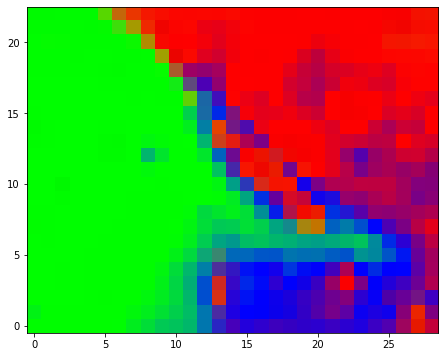

In [12]:

RCA_vector = rvc.predict(test)

print("fit score: ", score_func(rvc, test))

RCA_vector = np.abs(RCA_vector)
RCA_vector = RCA_vector - RCA_vector.min(0)
RCA_vector /= RCA_vector.max(0)

plt.figure(figsize = (20,6))
plt.imshow(RCA_vector.reshape((*shape_X[:2], 3))[::-1,:,:3])
plt.gca().invert_yaxis()
plt.show()